Sube tu Excel fusionado (ej. BibliometrixExportFile20250220.xlsx)…


Saving BibliometrixExportFile20250220.xlsx to BibliometrixExportFile20250220.xlsx
Columna de año: py | Keywords Plus: id
Rango temporal detectado: 1994–2025
Términos candidatos (Keywords Plus): 52 de 2294


Detectando bursts (ID): 100%|██████████| 52/52 [00:00<00:00, 77.23it/s]


CSV con todos los bursts (Keywords Plus): burst_keywords_plus_1994-2025.csv
CSV del top por intensidad (Keywords Plus): burst_keywords_plus_top20_1994-2025.csv


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

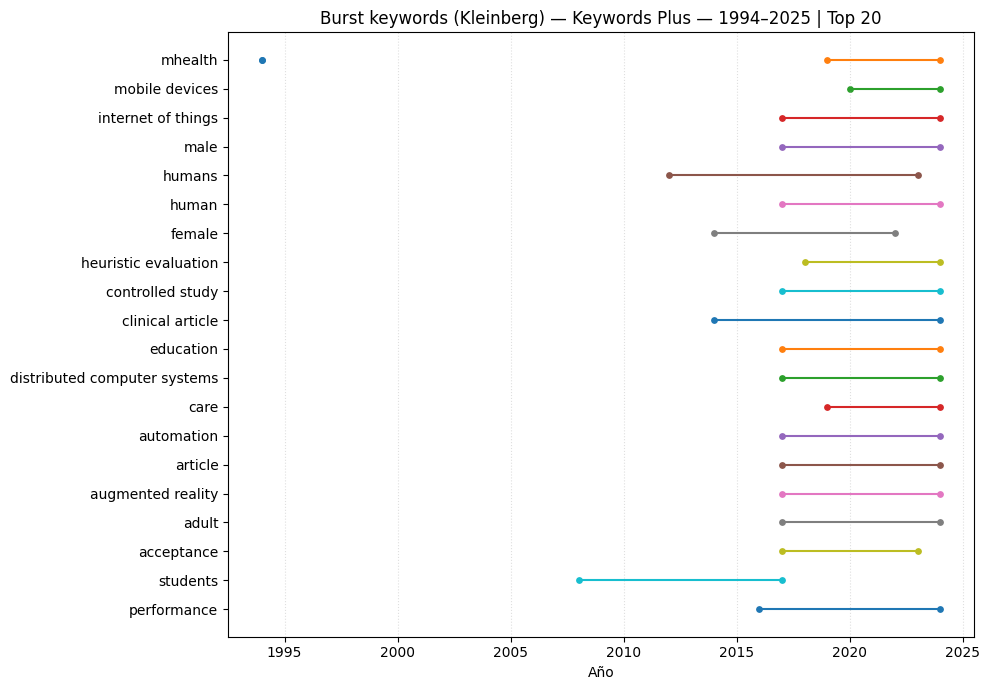

In [1]:
# ============================
# Burst Keywords (Kleinberg) en Google Colab — Keywords Plus (ID)
# Lee Excel Scopus+WoS, usa SOLO Keywords Plus (ID), detecta bursts y grafica.
# ============================

!pip -q install pandas openpyxl numpy matplotlib tqdm

import math
import re
import io
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from tqdm import tqdm
from google.colab import files

# ---------- 0) Subir y leer Excel ----------
print("Sube tu Excel fusionado (ej. BibliometrixExportFile20250220.xlsx)…")
uploaded = files.upload()
fname = list(uploaded.keys())[0]
df0 = pd.read_excel(io.BytesIO(uploaded[fname]))

# Limpieza básica de encabezados
df0.columns = [c.strip().lower() for c in df0.columns]

# ---------- 1) Detección de columnas ----------
# Año
year_col_candidates = [c for c in df0.columns if c in ["py", "publication_year", "year"]]
if not year_col_candidates:
    raise ValueError("No encuentro columna de año (esperaba 'PY'/'publication_year'/'year').")
year_col = year_col_candidates[0]

# Keywords Plus: prioriza 'id' o variantes tipo 'keywords plus'
id_col = None
if "id" in df0.columns:
    id_col = "id"
else:
    # Buscar patrones razonables de Keywords Plus (WoS) o índices
    for c in df0.columns:
        if re.search(r"(keywords?\s*\+|keywords?\s*plus|wos.*keywords|index.*terms?)", c):
            id_col = c
            break

if id_col is None:
    raise ValueError("No encuentro columna de Keywords Plus (ID). Revisa encabezados del Excel.")

print(f"Columna de año: {year_col} | Keywords Plus: {id_col}")

# ---------- 2) Construcción del dataframe (año, keyword ID) ----------
def to_text(x):
    # Manejo seguro de escalares
    if pd.isna(x):
        return ""
    return str(x)

sep_rx = r";|,"  # separadores típicos ; o ,
kw_raw = df0[id_col].apply(to_text)

tmp = pd.DataFrame({
    "py": pd.to_numeric(df0[year_col], errors="coerce").astype("Int64"),
    "kw_raw": kw_raw.fillna("").astype(str)
})

# Normalización ligera: minúsculas, trimming, separadores
kw_df = (
    tmp.dropna(subset=["py"])
       .assign(kw_raw=lambda d: d["kw_raw"].str.replace(r"\s*;\s*", ";", regex=True))
       .assign(kw_raw=lambda d: d["kw_raw"].str.replace(r"\s+", " ", regex=True))
       .assign(kw_raw=lambda d: d["kw_raw"].str.lower())
       .assign(keyword=lambda d: d["kw_raw"].str.split(sep_rx))
       .explode("keyword")
       .assign(keyword=lambda d: d["keyword"].str.strip())
       # Limpiezas menores de basura común en ID
       .assign(keyword=lambda d: d["keyword"].str.replace(r"^[\-–—]+|[\.\,;:\-–—]+$", "", regex=True))
       .query("keyword.notnull() and keyword != ''")
       .loc[:, ["py", "keyword"]]
       .drop_duplicates()
)

if kw_df.empty:
    raise SystemExit("Después de limpiar y explotar, no quedaron Keywords Plus. Revisa separadores o contenido de ID.")

yr_min, yr_max = int(kw_df["py"].min()), int(kw_df["py"].max())
years = list(range(yr_min, yr_max + 1))
print(f"Rango temporal detectado: {yr_min}–{yr_max}")

# ---------- 3) Tabla de frecuencias por keyword y año (pivot robusto) ----------
freq = (
    kw_df.groupby(["keyword", "py"])
         .size()
         .rename("freq")
         .reset_index()
)

# Pivot a matriz keyword x año, completa años faltantes, vuelve a long
freq_wide = (
    freq.pivot_table(index="keyword", columns="py", values="freq", aggfunc="sum")
        .reindex(columns=years, fill_value=0)
        .fillna(0)
        .astype(int)
)

freq_full = (
    freq_wide.stack()
             .rename("freq")
             .reset_index()
             .rename(columns={"level_1": "py"})
)

# ---------- 4) Kleinberg ----------
# Estados 0..K con tasas r_k = base * s**k
# Penalización por subir: ln(N) * gamma * max(0, j-i). Bajar no penaliza.
def kleinberg_bursts(counts, s=2.0, gamma=1.0, K=6):
    counts = np.asarray(counts, dtype=float)
    T = len(counts)
    N = counts.sum()
    if T == 0:
        return []
    if N == 0:
        return [0]*T

    base = N / T
    rates = np.array([base * (s ** k) for k in range(K)], dtype=float)
    with np.errstate(divide="ignore"):
        log_rates = np.log(rates)
    # Emisión: -log P(X=x|Poisson(r)) ignorando log(x!) común
    emit = np.outer(np.ones(T), rates) - np.outer(counts, log_rates)  # T x K

    lnN = math.log(max(N, 2))
    def tau(i, j):
        return lnN * gamma * max(0, j - i)

    dp = np.full((T, K), np.inf)
    prev = np.full((T, K), -1, dtype=int)
    dp[0, :] = emit[0, :]

    # precalcula transiciones
    trans = np.array([[tau(i, j) for j in range(K)] for i in range(K)])  # KxK
    for t in range(1, T):
        costs = dp[t-1, :].reshape(-1,1) + trans  # KxK
        best_prev = np.argmin(costs, axis=0)      # K
        dp[t, :] = costs[best_prev, range(K)] + emit[t, :]
        prev[t, :] = best_prev

    states = np.zeros(T, dtype=int)
    states[T-1] = int(np.argmin(dp[T-1, :]))
    for t in range(T-2, -1, -1):
        states[t] = prev[t+1, states[t+1]]
    return states.tolist()

def extract_bursts(states, years, s=2.0):
    bursts = []
    cur_state = 0
    start = None
    for i, st in enumerate(states):
        if st > 0 and cur_state == 0:
            start = i
        if st == 0 and cur_state > 0:
            end = i - 1
            level = cur_state
            bursts.append((years[start], years[end], level, (s ** level)))
            start = None
        cur_state = st
    if cur_state > 0 and start is not None:
        bursts.append((years[start], years[len(states)-1], cur_state, (s ** cur_state)))
    return pd.DataFrame(bursts, columns=["begin","end","level","strength"])

# ---------- 5) Ejecutar bursts por keyword (solo ID) ----------
# Filtros anti-ruido. Ajusta si tu corpus es pequeño/grande.
MIN_TOTAL = 5     # mínimo de apariciones totales del término
MIN_YEARS = 3     # mínimo de años con presencia

agg = (
    freq_full.groupby("keyword")
             .agg(total=("freq","sum"),
                  years_present=("freq", lambda x: (x>0).sum()))
             .reset_index()
)

valid_terms = agg.query("total >= @MIN_TOTAL and years_present >= @MIN_YEARS")["keyword"].tolist()
print(f"Términos candidatos (Keywords Plus): {len(valid_terms)} de {agg.shape[0]}")

# Parámetros de sensibilidad
S = 2.0
GAMMA = 1.0
K_STATES = 6

rows = []
for term in tqdm(valid_terms, desc="Detectando bursts (ID)"):
    series = (
        freq_full.loc[freq_full["keyword"]==term]
                 .sort_values("py")["freq"]
                 .to_numpy()
    )
    states = kleinberg_bursts(series, s=S, gamma=GAMMA, K=K_STATES)
    bursts = extract_bursts(states, years, s=S)
    if not bursts.empty:
        bursts.insert(0, "term", term)
        bursts["duration"] = bursts["end"] - bursts["begin"] + 1
        rows.append(bursts)

if not rows:
    raise SystemExit("No se detectaron bursts con los filtros actuales. Ajusta MIN_TOTAL/MIN_YEARS o S/GAMMA/K_STATES.")

br = pd.concat(rows, ignore_index=True)

# Orden por intensidad y duración
br_sorted = br.sort_values(["strength","duration"], ascending=[False, False]).reset_index(drop=True)

# ---------- 6) Guardar resultados ----------
out_all = f"burst_keywords_plus_{yr_min}-{yr_max}.csv"
br_sorted.to_csv(out_all, index=False)
print("CSV con todos los bursts (Keywords Plus):", out_all)

# Top N para visualización y CSV
TOP = 20
top_terms = (
    br_sorted.groupby("term")["strength"].max()
             .sort_values(ascending=False)
             .head(TOP)
             .index.tolist()
)
top_br = br_sorted[br_sorted["term"].isin(top_terms)].copy()
order = (
    top_br.groupby("term")["strength"].max()
          .sort_values(ascending=False)
          .index.tolist()
)
top_br["term"] = pd.Categorical(top_br["term"], categories=order, ordered=True)

out_top = f"burst_keywords_plus_top{TOP}_{yr_min}-{yr_max}.csv"
top_br.sort_values(["term","begin"]).to_csv(out_top, index=False)
print("CSV del top por intensidad (Keywords Plus):", out_top)

# Descarga directa en Colab
try:
    files.download(out_all)
    files.download(out_top)
except Exception as e:
    print("Descarga automática no disponible en este entorno:", e)

# ---------- 7) Plot de intervalos de burst ----------
plt.figure(figsize=(10, max(6, len(order)*0.35)))
for i, term in enumerate(order):
    tmp = top_br[top_br["term"]==term].sort_values("begin")
    y = len(order)-i
    for _, r in tmp.iterrows():
        plt.plot([r["begin"], r["end"]], [y, y])
        plt.scatter([r["begin"], r["end"]], [y, y], s=15)
plt.yticks(range(1, len(order)+1), order)
plt.xlabel("Año")
plt.title(f"Burst keywords (Kleinberg) — Keywords Plus — {yr_min}–{yr_max} | Top {TOP}")
plt.grid(axis="x", linestyle=":", alpha=0.4)
plt.tight_layout()
plt.show()

# ---------- 8) Bonus: serie temporal de un término concreto (Keywords Plus) ----------
focus_term = None  # escribe algo como 'human-computer interaction' en minúsculas
if focus_term:
    ft = str(focus_term).lower().strip()
    series = (
        freq_full[freq_full["keyword"]==ft]
        .sort_values("py")
    )
    if series.empty:
        print(f"'{focus_term}' no encontrado en Keywords Plus.")
    else:
        plt.figure(figsize=(8,3))
        plt.plot(series["py"], series["freq"])
        plt.scatter(series["py"], series["freq"], s=12)
        plt.title(f"Evolución (Keywords Plus): {focus_term}")
        plt.xlabel("Año"); plt.ylabel("Frecuencia")
        plt.grid(True, axis="y", linestyle=":", alpha=0.4)
        plt.tight_layout()
        plt.show()
